In [1]:
from __future__ import print_function
import argparse

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.misc as scpm
import math
import h5py
import copy
from tqdm import tqdm
from time import time
import joblib


/home/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
###############
## Load data ##
###############

batch_size=1000
n_mice=17
h5_temp = h5py.File('../whitened_clean_pca.h5','r')

In [3]:
################################
## Get rid of mouse with nans ##
################################

uuids_all = list(h5_temp.keys())
uuids = copy.deepcopy(uuids_all)
delete_inds=[]
for i in range(len(uuids_all)):
   # print(np.sum(np.isnan(h5_temp[uuids_all[i]][:])))
    if np.sum(np.isnan(h5_temp[uuids_all[i]][:]))>0:
        delete_inds.append(i)
for ii in sorted(delete_inds,reverse=True):
    del uuids[ii]
    
for i in range(n_mice):
   # print(uuids[i])
    if np.sum(np.isnan(h5_temp[uuids[i]][:])) > 0:
        print('ERROR: NANS STILL PRESENT')
        ver


In [4]:
############################
## CREATE DATA GENERATORS ##
############################

def data_generator(pca_file, uuids, batch_size,n_mice):
    
    total_batches=0
    n_batches = [None]*n_mice

    for i_mouse in range(n_mice):
        length_mouse = pca_file[uuids[i_mouse]].shape[0]
        n_batches[i_mouse] = np.floor(length_mouse/batch_size)

    total_batches = int(np.sum(n_batches))

    batch_inds = np.zeros((int(total_batches),2))
    i_pos=0
    
    for i_mouse in range(n_mice):
        for i_batch in range(int(n_batches[i_mouse])):
            batch_inds[i_pos,0] = i_mouse
            batch_inds[i_pos,1] = i_batch
            i_pos+=1

    loop_vec = np.arange(total_batches)
    
    
    for i_epoch in range(1000):
        np.random.shuffle(loop_vec)
        for ii in loop_vec:

            i_mouse = int(batch_inds[ii,0])
            which_batch = int(batch_inds[ii,1])

            yield pca_file[uuids[i_mouse]][which_batch*batch_size:(which_batch+1)*batch_size], i_mouse, which_batch 
            #, behavioral_labels[i_mouse][which_bucket][which_batch*batch_size:(which_batch+1)*batch_size],
            # depth[i_mouse][which_bucket][which_batch*batch_size:(which_batch+1)*batch_size],
            #i_mouse,which_bucket,which_batch


In [5]:
# Get number of training batches

pca_file = h5_temp
total_batches=0
n_batches = [None]*n_mice
for i_mouse in range(n_mice):
    length_mouse = pca_file[uuids[i_mouse]].shape[0]
    n_batches[i_mouse] = np.floor(length_mouse/batch_size)
total_batches = int(np.sum(n_batches))
nb_tng_batches = total_batches
print(nb_tng_batches)

901


In [6]:
# Create data generator
data_gen = data_generator(h5_temp,uuids,batch_size,n_mice)

In [7]:
ys = []
for i in range(nb_tng_batches):
    y, i_mouse, i_batch = next(data_gen)
    ys.append(y)

In [8]:
from ssm.models import HMM
arhmm = HMM(K=20,
            D=10,
            transitions="sticky",
            transition_kwargs=dict(kappa=1e8),
            observations="ar")

print(arhmm.transitions.kappa)

100000000.0


In [9]:
# arhmm.fit(ys, method="em", num_em_iters=50)
arhmm.initialize(ys)

In [10]:
arhmm.fit(ys, method="em", num_em_iters=50)

Iteration 0.  LP: -3574219.9
Iteration 1.  LP: -3058766.0
Iteration 2.  LP: -2923643.3
Iteration 3.  LP: -2836850.2
Iteration 4.  LP: -2786423.7
Iteration 5.  LP: -2760420.6
Iteration 6.  LP: -2746321.5
Iteration 7.  LP: -2737411.3
Iteration 8.  LP: -2731522.1
Iteration 9.  LP: -2727495.1
Iteration 10.  LP: -2724373.8
Iteration 11.  LP: -2721733.0
Iteration 12.  LP: -2719222.2
Iteration 13.  LP: -2716631.9
Iteration 14.  LP: -2714039.6
Iteration 15.  LP: -2711471.4
Iteration 16.  LP: -2708743.1
Iteration 17.  LP: -2706122.0
Iteration 18.  LP: -2703654.1
Iteration 19.  LP: -2701429.4
Iteration 20.  LP: -2699302.1
Iteration 21.  LP: -2697281.0
Iteration 22.  LP: -2695372.8
Iteration 23.  LP: -2693773.5
Iteration 24.  LP: -2692299.4
Iteration 25.  LP: -2690877.7
Iteration 26.  LP: -2689501.8
Iteration 27.  LP: -2688300.5
Iteration 28.  LP: -2687360.9
Iteration 29.  LP: -2686580.0
Iteration 30.  LP: -2685940.4
Iteration 31.  LP: -2685364.7
Iteration 32.  LP: -2684847.2
Iteration 33.  LP: -

[-3574219.8822441692,
 -3058766.032205494,
 -2923643.309756307,
 -2836850.185092483,
 -2786423.711828773,
 -2760420.6086429213,
 -2746321.524321586,
 -2737411.2951565096,
 -2731522.0550833414,
 -2727495.0669484227,
 -2724373.7889930136,
 -2721733.0275581595,
 -2719222.231466208,
 -2716631.889316234,
 -2714039.6049962672,
 -2711471.378993326,
 -2708743.084489292,
 -2706122.011953975,
 -2703654.051417536,
 -2701429.420598668,
 -2699302.1279701013,
 -2697280.96659896,
 -2695372.7767409957,
 -2693773.513282335,
 -2692299.38001914,
 -2690877.667517465,
 -2689501.8475861754,
 -2688300.5260284175,
 -2687360.9366160817,
 -2686580.01953802,
 -2685940.3588245763,
 -2685364.6546385214,
 -2684847.176746523,
 -2684363.8143078997,
 -2683936.249453064,
 -2683537.1013346133,
 -2683171.320849613,
 -2682835.294205432,
 -2682525.5447359886,
 -2682264.117915023,
 -2682057.0481043844,
 -2681880.5294342497,
 -2681727.7420992707,
 -2681592.8640007237,
 -2681467.4569667983,
 -2681355.7782727294,
 -2681252.698

In [11]:
Ezs = [arhmm.expected_states(y)[0] for y in ys]

In [12]:
zs = [arhmm.most_likely_states(y) for y in ys]

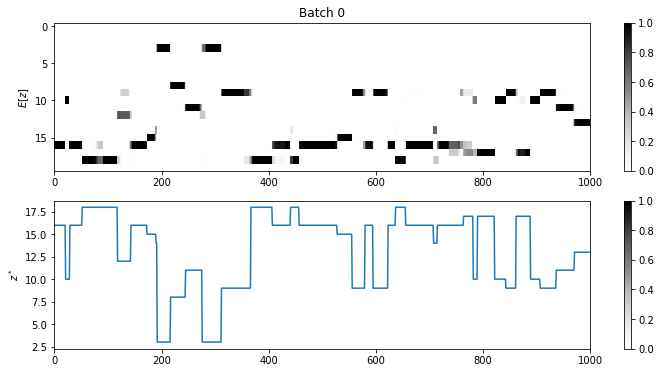

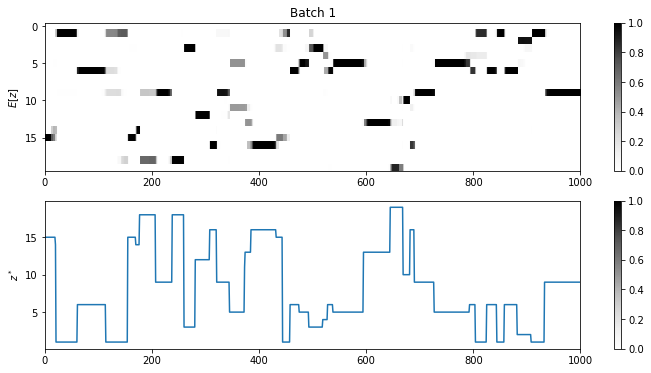

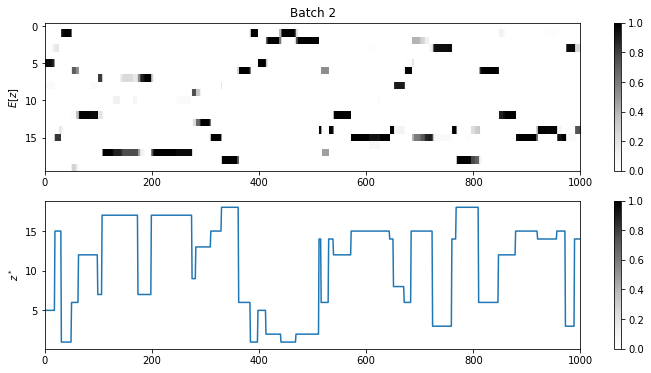

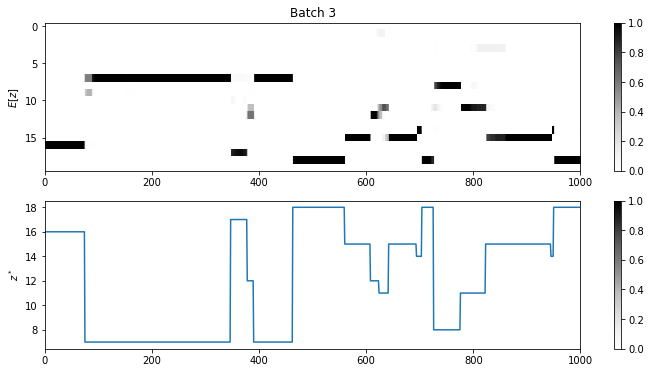

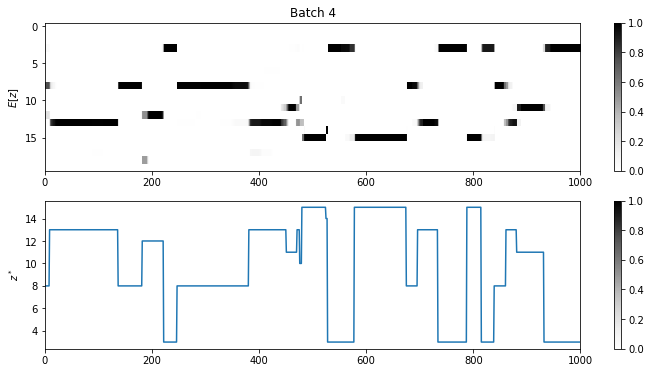

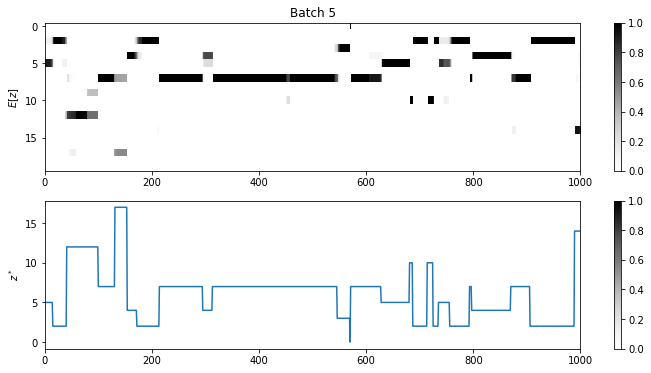

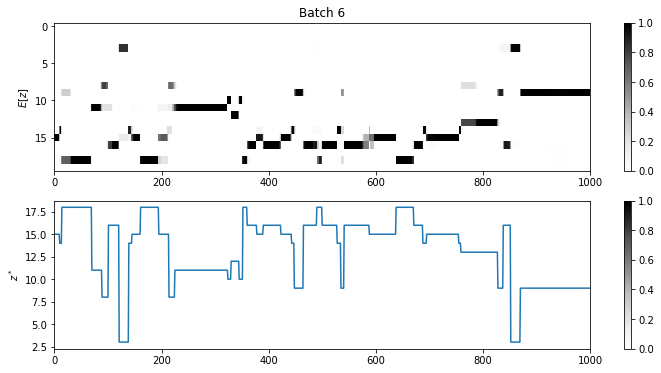

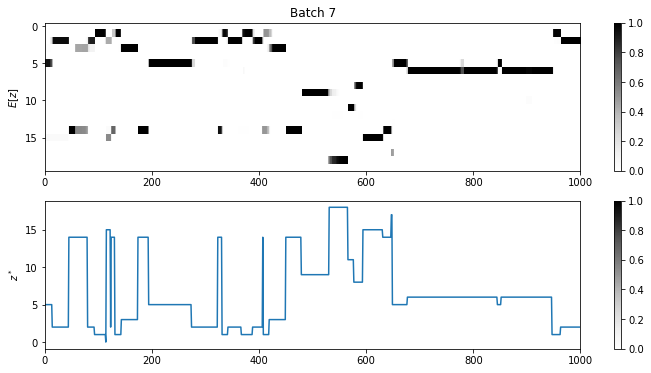

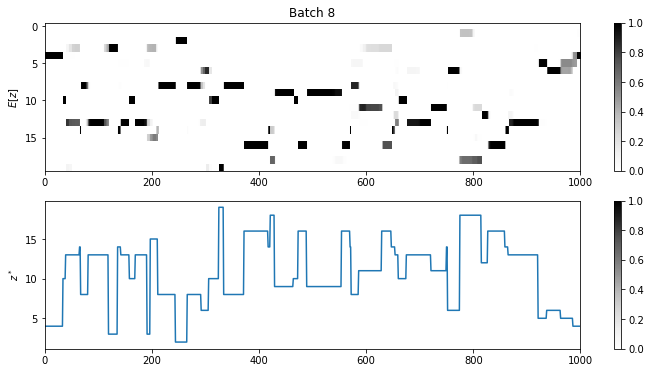

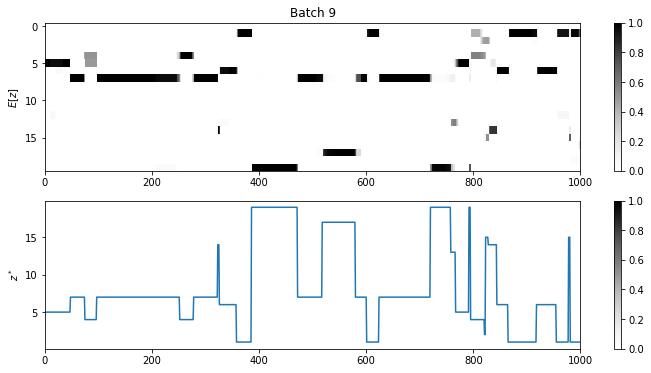

In [17]:
for i in range(10):
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.imshow(Ezs[i].T, aspect="auto", cmap="Greys")
    plt.ylabel("$E[z]$")
    plt.xlim(0, 1000)
    plt.title("Batch {}".format(i))
    plt.colorbar()

    plt.subplot(212)
    plt.plot(zs[i])
    plt.ylabel("$z^*$")
    plt.xlim(0, 1000)
    plt.colorbar()

Text(0,0.5,'Usage')

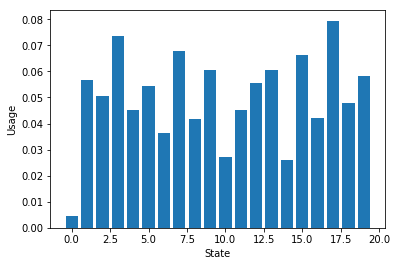

In [14]:
# Compute expected usage
usage = np.mean(np.vstack(Ezs), axis=0)
plt.bar(np.arange(arhmm.K), usage)
plt.xlabel("State")
plt.ylabel("Usage")

Text(0,0.5,'count')

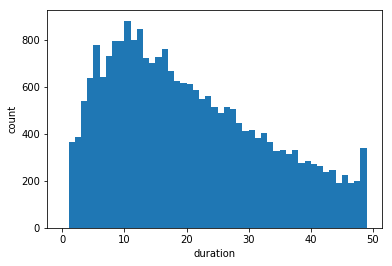

In [16]:
from pyhsmm.util.general import rle
durs = [rle(z)[1] for z in zs]

plt.hist(np.concatenate(durs), bins=np.arange(50))
plt.xlabel("duration")
plt.ylabel("count")